# Reading ADI Sequence

## Imports

In [153]:
%matplotlib inline
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import numpy as np
from importlib import reload

import vip_hci as vip
from hciplot import plot_frames, plot_cubes

from vip_hci.config import VLT_NACO
from vip_hci.fm import normalize_psf, cube_inject_companions
from vip_hci.psfsub import median_sub, pca, pca_annular, pca_annulus

from vip_hci.fits import open_fits, write_fits, info_fits
from vip_hci.metrics import significance, snr, snrmap
from vip_hci.var import fit_2dgaussian, frame_center

from vip_hci.preproc.cosmetics import cube_crop_frames, frame_crop
from vip_hci.preproc import frame_rotate
from vip_hci.config.utils_conf import pool_map, iterable

import training_set_generation_functions
reload(training_set_generation_functions)
from training_set_generation_functions import inject_random_fake_comp, adi_mlar_pca, crop, make_mlar_minus, get_fwhm, evaluate_snr, plot_patch, flux_interval, patch_rotation, patch_shift, patch_average, save_to_h5, read_h5, make_residual_cube, plot_10_random
import new_1
reload(new_1)
from new_1 import C_plus_class, C_minus_class


In [149]:
adi=np.load('adi_sequence/adi_seq.npy')
pa=np.load('adi_sequence/pa.npy')
psf=np.load('adi_sequence/psf.npy')
pxscale=np.load('adi_sequence/pxscale.npy')

fwhm = get_fwhm(psf)
an_nbr=5
an_radius = an_nbr*fwhm
snr_interv=(1,3)
ncomp= 3
nproc=2
sample_nbr=2
flux_stat=2

In [154]:
a = C_plus_class(adi, pa, psf, pxscale, an_nbr, 2, nproc, ncomp, data_aug=True, runtime=True)

Flux in 1xFWHM aperture: 0.994
injecting done
Execution time: 5.009928226470947 seconds
CPU Execution time: 0.0625 seconds 

PCA done
Execution time: 5.951350688934326 seconds
CPU Execution time: 0.03125 seconds 

<class 'list'>
cropping done
Execution time: 5.0742576122283936 seconds
CPU Execution time: 0.0 seconds 

data_augmentation 

rotation done
Execution time: 5.1681435108184814 seconds
CPU Execution time: 0.0 seconds 

shift done
Execution time: 9.781970739364624 seconds
CPU Execution time: 0.0 seconds 

average done
Execution time: 5.361407041549683 seconds
CPU Execution time: 0.0 seconds 



In [162]:
print(a)

([array([[[ 5.06744385e-02,  1.00543833e+00,  2.60370255e-01,
          7.48711109e-01,  8.35103989e-02, -9.92941856e-01,
         -1.60788631e+00, -2.06097746e+00, -1.58321857e+00],
        [-3.04605484e-01, -1.58933640e-01,  1.56159019e+00,
          1.95965767e-02, -5.90774059e-01, -1.14886570e+00,
         -1.69961977e+00, -1.73971653e+00, -1.32063437e+00],
        [ 8.43076706e-01,  1.53085184e+00,  1.66025925e+00,
          1.53704739e+00,  1.31974792e+00,  4.75765228e-01,
         -6.87670231e-01, -9.03409958e-01, -4.22704697e-01],
        [ 1.04848862e+00,  1.03754234e+00,  1.30310631e+00,
          2.92590332e+00,  3.28890038e+00,  2.60701275e+00,
          1.20529890e+00,  2.24349976e-01,  1.23561859e-01],
        [ 6.66384697e-01,  2.89648056e-01,  1.66938400e+00,
          4.30838203e+00,  6.06163025e+00,  5.30140972e+00,
          3.09983015e+00,  2.06023788e+00,  3.61484528e-01],
        [ 5.92787743e-01,  7.21683502e-01,  1.62905264e+00,
          4.05540466e+00,  6.0921

In [150]:
b = C_minus_class(adi, pa, psf, pxscale, an_nbr, 2, nproc, ncomp, data_aug=True, runtime=True)

PCA done
Execution time: 5.300898790359497 seconds
CPU Execution time: 0.03125 seconds 

(1, 3, 160, 160)
cropping done
Execution time: 5.111492156982422 seconds
CPU Execution time: 0.015625 seconds 

data_augmentation 

rotation done
Execution time: 5.1650450229644775 seconds
CPU Execution time: 0.0 seconds 

shift done
Execution time: 26.116203546524048 seconds
CPU Execution time: 0.015625 seconds 

average done
Execution time: 5.5039403438568115 seconds
CPU Execution time: 0.0 seconds 



In [170]:
type(b)

list

In [4]:

inj_adi=[]                 #keep adi cubes that have been injected with a satisfying S/N value
snr_values=[]
good_values=[]             # S/N, flux, injection position corrseponding to adi cubes in inj_adi
patches_plus=[]
adi_with_fake_comp, flevel = inject_random_fake_comp(adi, psf, pxscale, pa, fwhm, an_radius, inj_nbr=flux_stat, nproc=6)

inj_pos=[(i[1][0][1],i[1][0][0]) for i in adi_with_fake_comp]

adi_with_fake_comp=[i[0] for i in adi_with_fake_comp]
snr_res = evaluate_snr(adi_with_fake_comp, pa, fwhm, inj_pos, an_radius, nproc=6)  #[[posy, posx,flux, array(flux_appertures), s/r],....]

#snr_values.append([snr_vale, f_source, sourcex, sourcey])
for i in range(len(snr_res)):
    if snr_res[i][4]>snr_interv[0] and snr_res[i][4]<snr_interv[1]:
        inj_adi.append(adi_with_fake_comp[i])
        good_values.append([snr_res[i][0], snr_res[i][1], snr_res[i][2], snr_res[i][3]])

snr_values=[[i[4],i[2]] for i in snr_res]

Flux in 1xFWHM aperture: 0.994


In [11]:
rot_options={'imlib':'skimage', 'interpolation':'bicubic'}
adi_with_fake_comp=np.array(adi_with_fake_comp)
f=pca_annulus(adi_with_fake_comp, pa, ncomp, 3*fwhm, an_radius, cube_ref=None, svd_mode='lapack', scaling=None, collapse='median', weights=None, collapse_ifs='mean', **rot_options)

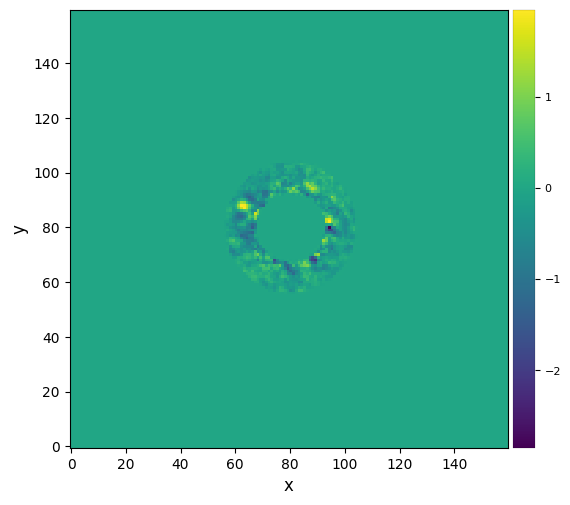

In [12]:
plot_frames(f)

## Loading ADI sequence from current directory

In [39]:
adi=np.load('adi_seq.npy')
pa=np.load('pa.npy')
psf=np.load('psf.npy')
pxscale=np.load('pxscale.npy')

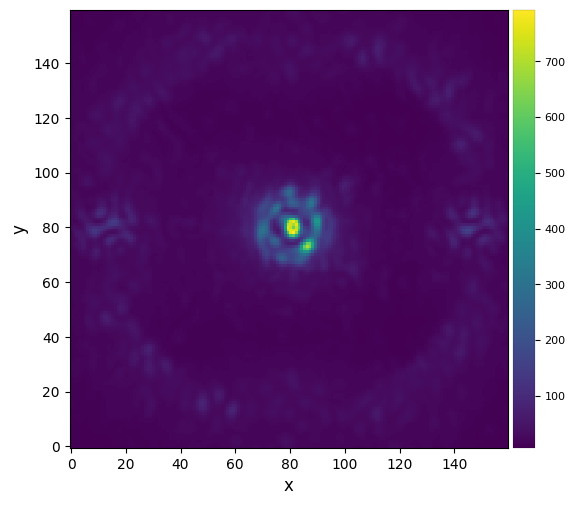

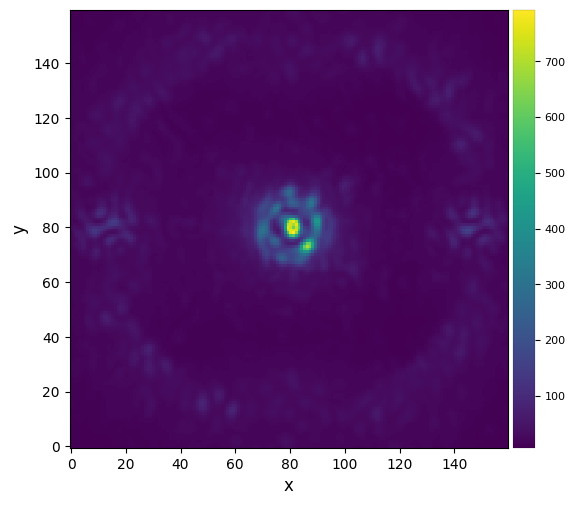

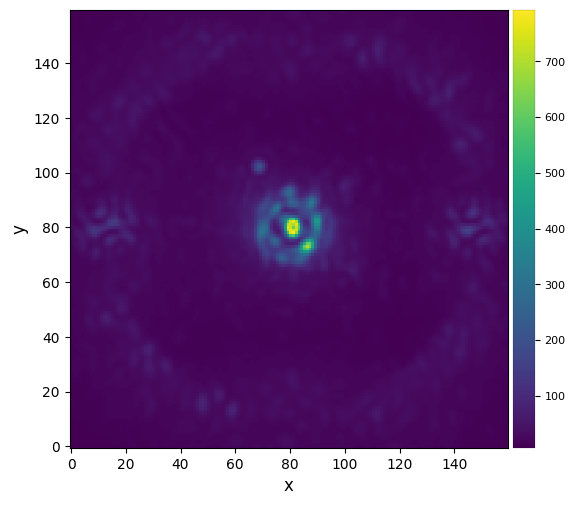

In [5]:
plot_frames(adi[0])
mod_adi=cube_inject_companions(adi, psf, pa, flevel=1500, plsc=pxscale, rad_dists=25, theta=0, imlib='opencv', interpolation='bicubic', full_output=False)
plot_frames(adi[0])
plot_frames(mod_adi[0])

## Substracting provided PSF

New shape: (41, 41)


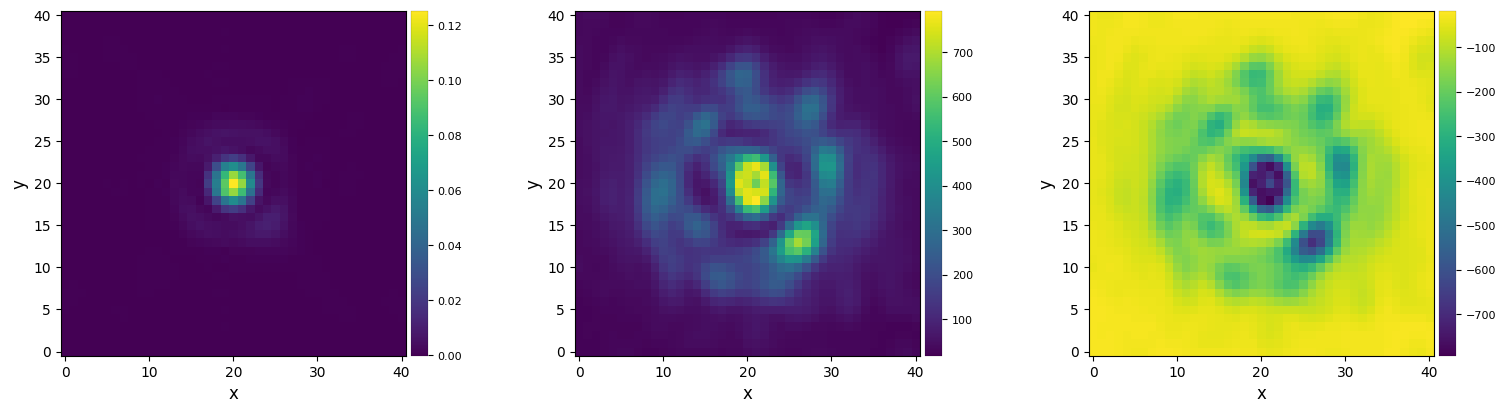

In [4]:
adi0_sub = vip.preproc.frame_crop(adi[0],len(psf),cenxy=(len(adi[0])/2,len(adi[0])/2), force=True )
plot_frames((psf, adi0_sub, psf - adi0_sub ))

## Performing median substraction

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-10-28 00:07:28
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:13.386332
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


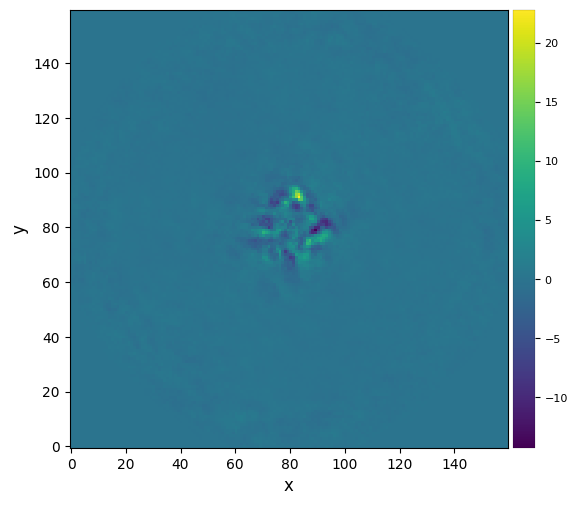

In [5]:
fr_adi = median_sub(adi, pa, mode='fullfr' , imlib = 'vip-fft', interpolation='none')
plot_frames((fr_adi))

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-10-28 00:07:42
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 8.161 GB
System available memory = 3.293 GB
Done vectorizing the frames. Matrix shape: (80, 25600)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.598629
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:00:18.722618
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


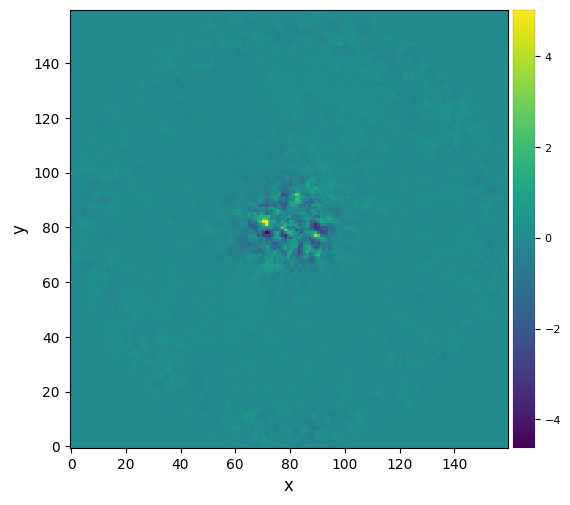

In [6]:
fr_pca1 = pca(adi, pa, ncomp=5, mask_center_px=None, imlib='vip-fft', interpolation='none',
              svd_mode='lapack')
plot_frames((fr_pca1))

# C+ class generation
## injecting a fake companion in 1 adi cube

Here the fake companion is injected at r= 5.5*fwhm (being the centre of the annulus having an inside diametre of $5 \lambda/D$ and outside diameter of $6 \lambda/D$) and 0° angle with a flux equal to (flux_min+flux_max)/2 corresponding to the arithmetic mean of the the fluxes leading to a S/N $\in$ [1,3] (as computed above)

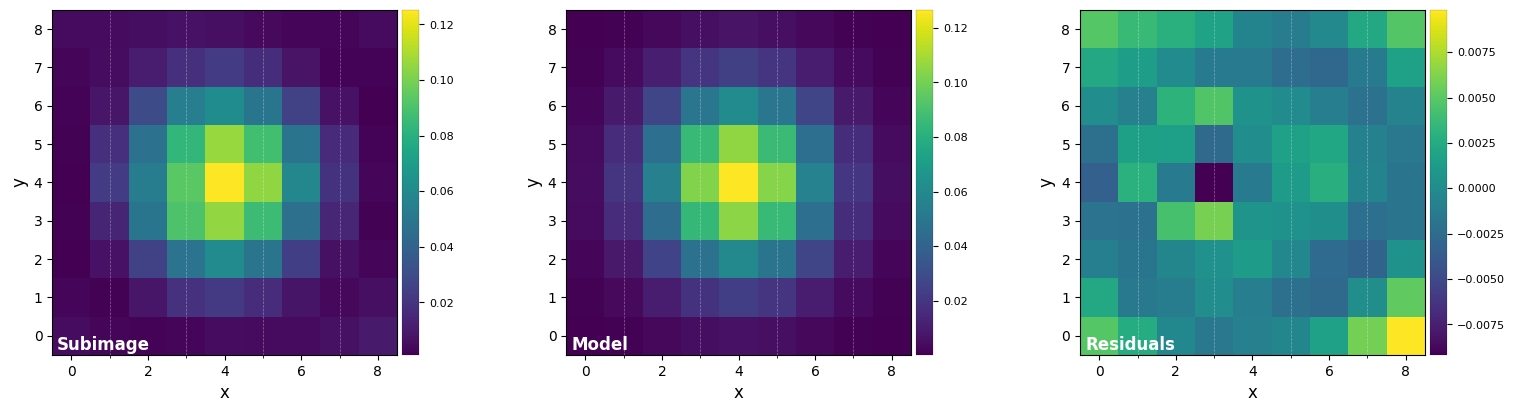

FWHM_y = 3.8683973545822607
FWHM_x = 3.6684473919771023 

centroid y = 20.01540679237611
centroid x = 20.010679376110478
centroid y subim = 4.015406792376109
centroid x subim = 4.010679376110477 

amplitude = 0.12659284517153813
theta = 3.777210099096072


In [7]:
DF_fit = fit_2dgaussian(psf, crop=True, cropsize=9, debug=True, full_output=True)
fwhm = np.mean([DF_fit['fwhm_x'],DF_fit['fwhm_y']])

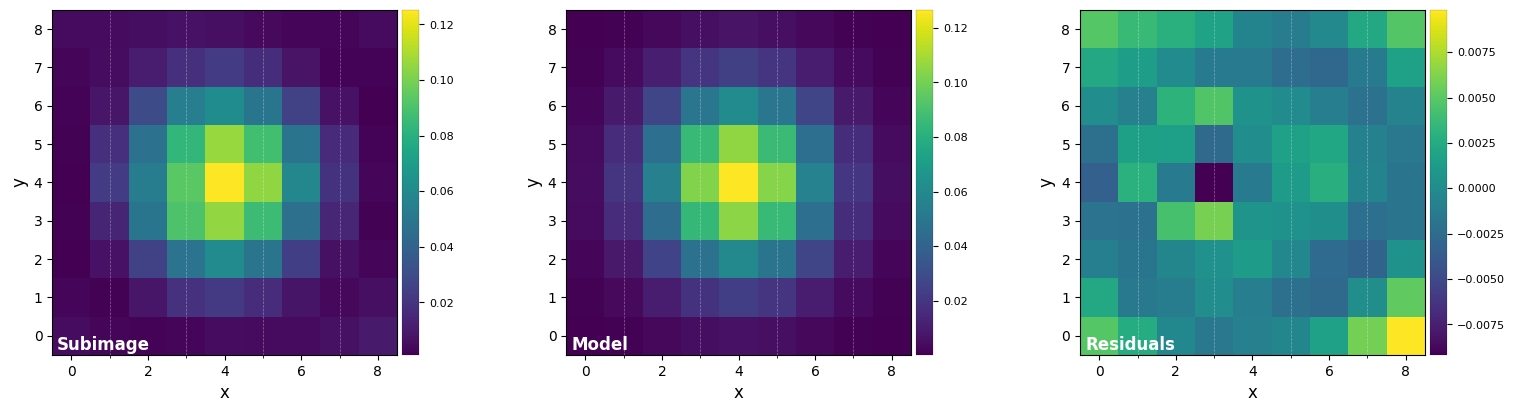

FWHM_y = 3.8683973545822607
FWHM_x = 3.6684473919771023 

centroid y = 20.01540679237611
centroid x = 20.010679376110478
centroid y subim = 4.015406792376109
centroid x subim = 4.010679376110477 

amplitude = 0.12659284517153815
theta = 3.7772100990960773
3.7684223732796815


In [40]:
DF_fit = fit_2dgaussian(psf, crop=True, cropsize=9, debug=True, full_output=True)
fwhm = np.mean([DF_fit['fwhm_x'],DF_fit['fwhm_y']])   #using gaussian fit to get FWHM
print(fwhm)
#norm_psf = normalize_psf(psf, fwhm=fwhm, model='gauss', imlib='opencv', interpolation='bicubic')       #Normalizing PSF
#adi_with_fake_comp, inj_pos = vip.fm.cube_inject_companions(adi, psf, pa, flevel= (flux_min+flux_max)/2, plsc=pxscale, rad_dists=5.5*fwhm, theta=0, imlib='opencv', interpolation='bicubic', full_output=True)
#inj_pos=inj_pos[0]

In [8]:
cropped_adi = vip.preproc.cosmetics.cube_crop_frames(adi, len(psf), xy=(len(adi)/2,len(adi/2)), force=True, verbose=True, full_output=False)
cropped_adi_pca = vip.psfsub.pca_annular(cropped_adi, pa, fwhm=fwhm, ncomp=5, svd_mode='lapack')   #Choose ncomp properly ?
snrmap_1 = snrmap(cropped_adi_pca, fwhm=fwhm, plot=False)
bnd_1 = np.unravel_index(np.argmin(abs(snrmap_1 - 1), axis=None), snrmap_1.shape)
bnd_2 = np.unravel_index(np.argmin(abs(snrmap_1 - 3), axis=None), snrmap_1.shape)
flux_min = cropped_adi_pca[bnd_1]
flux_max = cropped_adi_pca[bnd_2]

New shape: (80, 41, 41)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-10-28 00:08:01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 5, FWHM = 3.768
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 10.76    Ann center:   2    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.074665
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh: 11.66    Ann center:   6    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.139742
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh: 11.83    Ann center:  10    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.234797
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh: 11.91    Ann center:  14    N segments: 1 
Done P

Performing PCA on the adi cube with 15 components

In [54]:
adi_with_fake_comp_pca = pca_annular(adi_with_fake_comp, pa, fwhm=fwhm, ncomp= 15, radius_int=5*fwhm, asize=fwhm, svd_mode='lapack', imlib='vip-fft', interpolation=None)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-10-31 18:17:47
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 16, FWHM = 3.768
PCA per annulus (or annular sectors):
Ann 1    PA thresh:  1.04    Ann center:  21    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.330307
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  1.41    Ann center:  24    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.633014
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  1.68    Ann center:  28    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.946963
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  1.89    Ann center:  32    N segments: 1 
Done PCA with lapack for curr

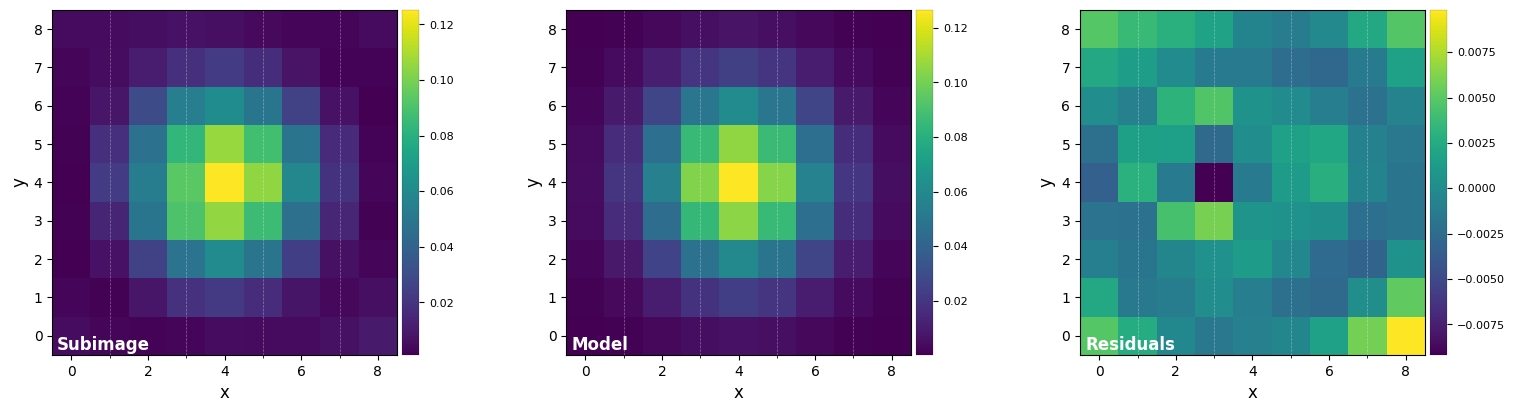

FWHM_y = 3.8683973545822607
FWHM_x = 3.6684473919771023 

centroid y = 20.01540679237611
centroid x = 20.010679376110478
centroid y subim = 4.015406792376109
centroid x subim = 4.010679376110477 

amplitude = 0.12659284517153813
theta = 3.777210099096072
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-11-01 14:12:43
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 20, FWHM = 4.000
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 11.42    Ann center:   2    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.065155
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  5.62    Ann center:   6    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.190998
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  4.46    Ann center:  10    N se

IndexError: index 135 is out of bounds for axis 0 with size 41

In [77]:
DF_fit = fit_2dgaussian(psf, crop=True, cropsize=9, debug=True, full_output=True)
fwhm = np.mean([DF_fit['fwhm_x'],DF_fit['fwhm_y']])   #using gaussian fit to get FWHM

adi_pca = pca_annular(adi, pa, ncomp=5, imlib='open_cv', interpolation='bicubic',svd_mode='lapack')
snrmap_1 = snrmap(adi_pca, fwhm=fwhm, plot=False)
bnd_1 = np.unravel_index(np.argmin(abs(snrmap_1 - 1), axis=None), snrmap_1.shape)
bnd_2 = np.unravel_index(np.argmin(abs(snrmap_1 - 3), axis=None), snrmap_1.shape)
flux_min = cropped_adi_pca[bnd_1]
flux_max = cropped_adi_pca[bnd_2]


norm_psf = normalize_psf(psf, fwhm=fwhm, model='gauss', imlib='opencv', interpolation='bicubic')       #Normalizing PSF
adi_with_fake_comp, inj_pos = vip.fm.cube_inject_companions(adi, psf, pa, flevel= flux_max, plsc=pxscale, rad_dists=5.5*fwhm, theta=0, imlib='opencv', interpolation='bicubic', full_output=True)
inj_pos=inj_pos[0]

In [80]:
ncomp=5
patch_width = np.ceil(2*fwhm) // 2 * 2 + 1    # rounding to the nearest odd integer
patch_width = int(patch_width)

MLAR_patch=[]

for i in range(1, ncomp+1):
    adi_with_fake_comp_pca = pca_annular(adi_with_fake_comp, pa, fwhm=fwhm, ncomp=i+1, svd_mode='lapack', imlib='skimage', interpolation='bicubic', verbose=False)
    MLAR_patch.append(vip.preproc.cosmetics.frame_crop(adi_with_fake_comp_pca, patch_width, cenxy=inj_pos, force=True))

New shape: (9, 9)
New shape: (9, 9)
New shape: (9, 9)
New shape: (9, 9)
New shape: (9, 9)


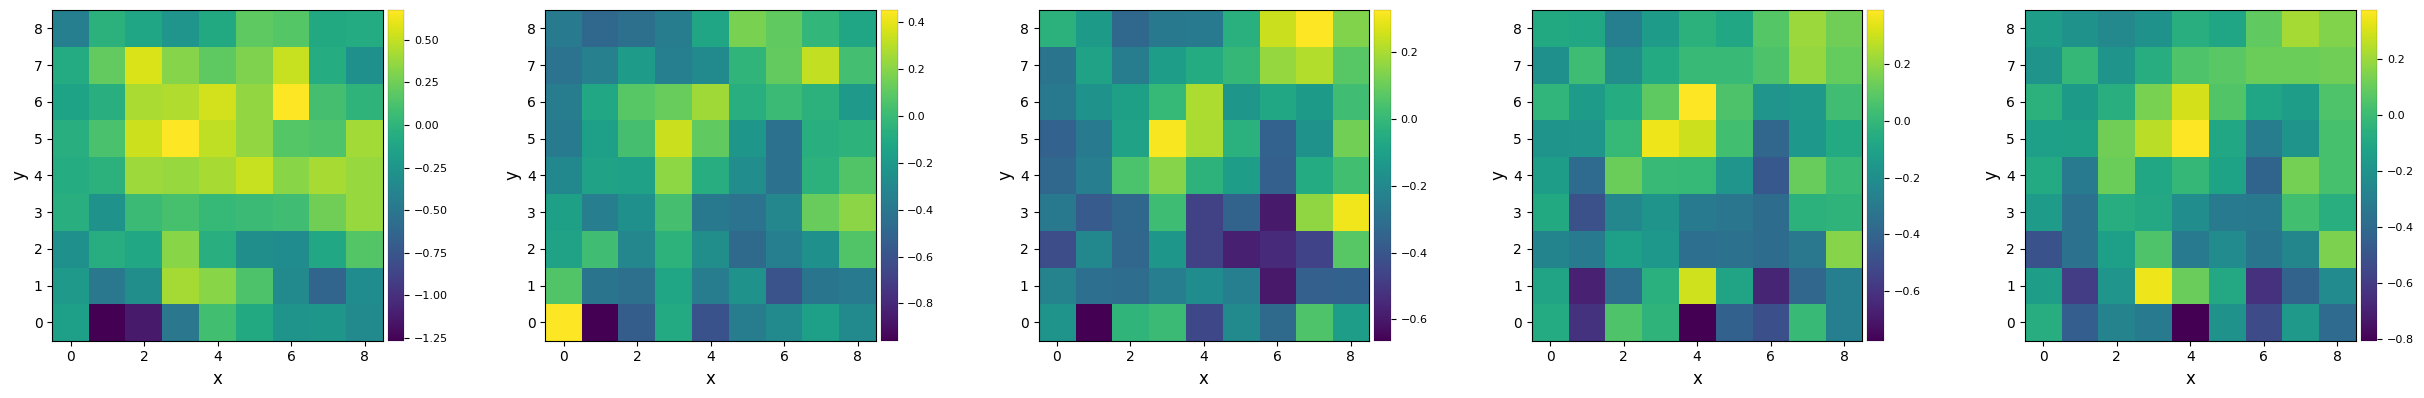

In [81]:
plot_frames(tuple(MLAR_patch[i] for i in range(ncomp)))

In [22]:
patches_plus=np.load('patches_plus_5L_D.npy')
patches_plus_aug=np.load('patches_plus_aug_5L_D.npy')
patches_minus=np.load('patches_minus_5L_D.npy')
patches_minus_aug=np.load('patches_minus_aug_5L_D.npy')

In [11]:
ncomp=3

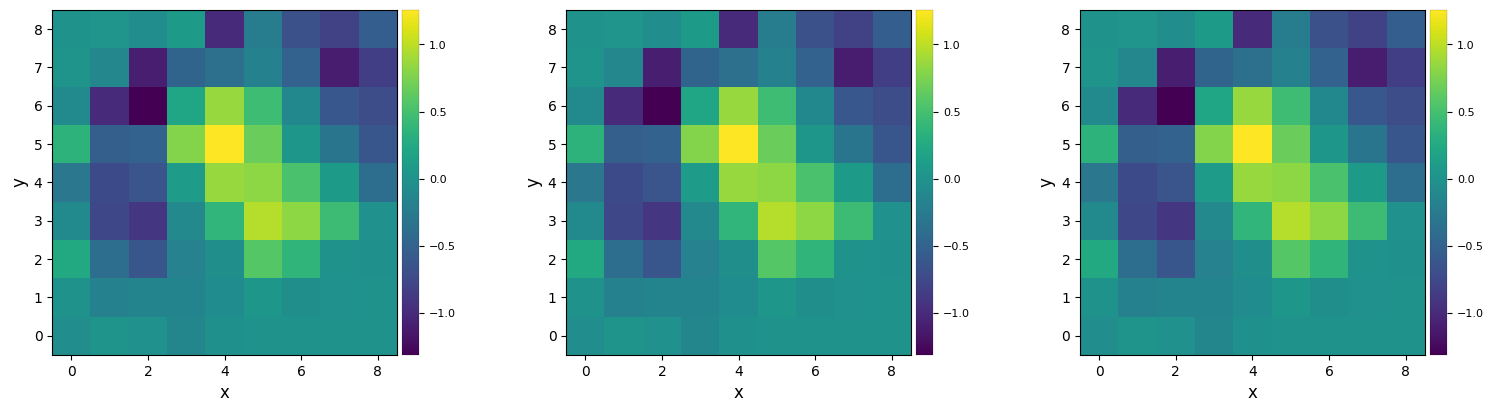

In [23]:
plot_frames(tuple(patches_plus[0]))

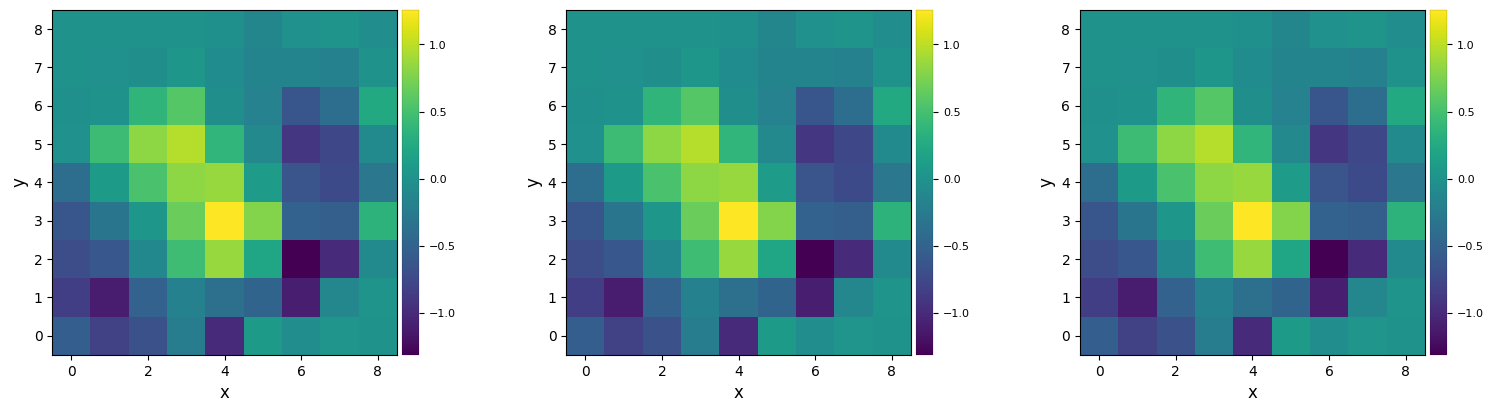

In [32]:
rot = [frame_rotate(i, 180, imlib='vip-fft', interpolation='lanczos4', cxy=None, border_mode='constant', edge_blend=None, interp_zeros=False, ker=1) for i in patches_plus[0]]
plot_frames(tuple(rot))

In [36]:
a=np.array([[1,2,3],[4,5,6],[7,8,9]])
print(a[:,0])

[1 4 7]


In [1]:
from vip_hci.config.utils_conf import pool_map, iterable

In [2]:
def rand_mu(x):
    return x*x, 'hello'

In [18]:

from vip_hci.preproc.cosmetics import cube_crop_frames, frame_crop
from vip_hci.preproc import frame_rotate
from vip_hci.preproc.recentering import frame_shift

In [3]:
help(cube_crop_frames)

Help on function cube_crop_frames in module vip_hci.preproc.cosmetics:

cube_crop_frames(array, size, xy=None, force=False, verbose=True, full_output=False)
    Crops frames in a cube (3d or 4d array).
    
    Parameters
    ----------
    array : numpy ndarray
        Input 3d or 4d array.
    size : int
        Size of the desired central sub-array in each frame, in pixels.
    xy : tuple of ints
        X, Y coordinates of new frame center. If you are getting the
        coordinates from ds9 subtract 1, python has 0-based indexing.
    force : bool, optional
        ``size`` and the original size of the frames must be both even or odd.
        With ``force`` set to True this condition can be avoided.
    verbose : bool optional
        If True message of completion is showed.
    full_output: bool optional
        If true, returns cenx and ceny in addition to array_view.
    
    Returns
    -------
    array_out : numpy ndarray
        Cube with cropped frames.

